# Earthquakes / DQ3

**REQUIREMENTS**
1. Read the table of earthquakes from [List of Deadly Erathquakes Since 1900](https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900) using *beautifulsoup* and load to a pandas dataframe.
2. Clean the data.
   - Replace empty strings with NaN
   - Remove the footnotes from the 'Other Source Deaths' column
   - Convert Magnitude to a numeric
   - Create a new column `deaths` that evaluates the *four total-death columns*:  `PDE Total Deaths, Utsu Total Deaths, EM-DAT Total Deaths, and Other Source Deaths` and populates the new column with the *highest* value.
3. Explore the data in terms of *when* and *where* earthquakes occurred and how severe they were (magnitude, deaths, secondary effects)

**What is an earthquake??**
> A sudden and violent shaking of the ground, sometimes causing great destruction, as a result of movements within the earth's crust or volcanic action.

***

# Table of Contents

### Setup
1. [Import the required libraries](#import-libraries)
2. [Create GDF method](#create-gdf)

### Obtaining Data
1. [Define Web Scraping Class](#web-scraping-to-df)
2. [Scrape for Earthquakes](#scrape-earthquakes)
3. [Scrape for Volcanoes](#scrape-volcanoes)
4. [Scrape for Vents](#scrape-vents)
5. [Import Tectonic Plate Boundaries and Countries for Mapping](#import-plate-countries-geojson)

### Clean the Data
1. [Define Base Level Clening Class](#base-clean-data)
2. [Define Earthquake Cleaning Class](#earthquakes-clean-data)
3. [Clean Earthquake Data](#clean-earthquakes)

### Exploration
1. [Analyze Magnitude Values](#analyze-magnitude)
    - [Prerequisites](#mag-prerequisite)
    - [Magnitude vs. Max-Deaths Correlation](#magnitude-max-deaths-corr)
    - [Tangshan Earthquake](#tangshan-earthquake)
    - [Top Fives (Mag, Death, and Depth)](#top-fives)
    - [Plot Top Fives](#top-five-map)
2. [Analyze by Quantity](#analysis-by-quantity-bar-graph)
3. [Pair Plot (Magnitude, Depth, Death, Year)](#pair-plot-corr)
4. [Death Count Frequency Correlation](#death-count-frequency-corr)
5. [Analyze Against New Data](#intro-to-new-data)
    1. [Define Volcanoes Cleaning Class](#volcanoes-clean-data)
    2. [Clean Volcanoes Data](#clean-volcanoes)
    3. [Define Vents Cleaning Class](#vents-clean-data)
    4. [Clean Vents Data](#clean-vents)
    5. [Plot Earthquakes, Volcanoes, and Vents on Map](#earthquakes-volcanoes-vents-map-1)
    6. [Read in Boudaries Data](#read-in-boundaries)
    7. [Establish Closest Point Logic Class](#closest-point-logic-class)
    8. [Intro to Volcanoes](#volcano-prerequisites)
        - [Find Closest Pts.](#volcanoes-closest-points)
        - [Closest Pts. Map 1](#volcanoes-closest-point-map-1)
        - [Closest Pt. Bar Plot 1](#volcanoes-closest-point-bar-plot-1)
        - [Normalize Pts.](#normalize-volcano-closest-points)
        - [Closest Pt. Bar Plot 2 (Normalize)](#plot-normalized-nearest-volcano)
        - [Closest Pt. Pair Plot](#closest-vol-mag-pair-plot)
    9. [Intro to Boundaries](#boundaries-prerequisites)
        - [Find Closest Pts.](#plates-closest-points)
        - [Closest Pts. Map 1](#plates-closest-point-map-1)
        - [Closest Pts. Bar Plot 1](#plates-closest-point-bar-plot-1)
        - [Normalize Pts.](#normalize-plates-closest-points)
        - [Closest Pt. Bar Plot 2 (Normalized)](#plot-normalized-nearest-plates)


<a id='import-libraries'></a>

In [1]:
from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

import datetime

<a id='create-gdf'></a>

In [2]:
def create_gdf(df):
    geometry = [Point(xy) for xy in zip(df.lng, df.lat)]
        
    crs = {"init": "epsg:4326"} 
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

<a id='web-scraping-to-df'></a>

In [3]:
class WebScrapingToDF(object):
    def __init__(self, url):
        self._url = url
    
    def start(self, table_class="sortable wikitable"):
        """
            1. make initial request
            2. turn the request into soup object
            3. get table
            4. from table get columns and rows
            5. return pandas dataframe of data obtained
        """
        url_html = self._make_request()
        soup = BS(url_html, 'html.parser')
        
        table = WebScrapingToDF._get_table(soup, table_class=table_class)
        
        columns = WebScrapingToDF._get_headers(table)
        rows = WebScrapingToDF._get_rows(table)
        
        return pd.DataFrame(data=rows, columns=columns)
    
    def _make_request(self):
        request = urllib.request.Request(self._url)
        result = urllib.request.urlopen(request)
        return result.read()
    
    @staticmethod
    def _get_table(soup, table_class):
        table_html = soup.find_all('table', class_=table_class)
        return table_html[0]
    
    @staticmethod
    def _get_headers(table):
        table_headers = table.find_all("th")
        return [th.text for th in table_headers]
    
    @staticmethod
    def _get_rows(table):
        rows = []
        for tr in table.find_all("tr")[1:]:
            row_data = [td.text for td in tr.find_all("td")]
            rows.append(row_data)
            
        return rows
    

<a id='create-gdf'></a>

# We are using data from multiple resources. Here is all the links we used to gather this info!!! Results are all dataframes :D 

<a id='scrape-earthquakes'></a>

In [4]:
# Gather earthquakes info
earthquakes_scraping = WebScrapingToDF(url="https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900")
earthquakes = earthquakes_scraping.start()

<a id='scrape-volcanoes'></a>

In [5]:
# Gather volcano info
volcanoes_scraping = WebScrapingToDF(url="http://volcano.oregonstate.edu/volcano_table")
volcanoes = volcanoes_scraping.start(table_class="views-table cols-6")

<a id='scrape-vents'></a>

In [6]:
# Gather vents info
vents_scraping = WebScrapingToDF(url="http://vents-data.interridge.org/ventfields_list_all")
vents = vents_scraping.start(table_class="views-table cols-8")

<a id='import-plate-countries-geojson'></a>

In [7]:
"""Import plates and countries geojson to plot"""
plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")

<a id='base-clean-data'></a>

In [8]:
class CleanData(object):
    def __init__(self, df):
        self._df = df
        
    def clean_col_by_regex(self, regex, column):
        self._df[column] = self._df[column].str.replace(regex, "")
        
    def nan_to_float32(self, columns, value=0, inplace=True):    
        for col in columns:        
            self._df[col].fillna(value=value, inplace=inplace)
            self._df[col] = pd.to_numeric(self._df[col], downcast='float')
            
    def strip_columns(self, columns):
        for column in columns:
            self._df[column] = self._df[column].str.strip()      

<a id='earthquakes-clean-data'></a>

## Cleaning the Earthquake Data

In [9]:
class CleanEarthquakes(CleanData):
    def __init__(self, df):
        super(CleanEarthquakes, self).__init__(df)
        
    def clean_cols_by_extract(self, columns, regex):
        for col in columns:
            self._df[col] = self._df[col].str.extract(regex, expand=True)
        
    def convert_nan_lat_lng(self, is_nan):
        """There are son lat/lng values in the dataframe that didn't exist on the wiki page, so we looked up the coords
            and assigned them to their appropriate location

            First index is LNG, second is LAT
        """
        for loc, coords in is_nan.items():
            self._df.iloc[loc, self._df.columns.get_loc('lng')] = coords[0]
            self._df.iloc[loc, self._df.columns.get_loc('lat')] = coords[1]

        assert self._df[self._df["lat"].isnull()].empty == True
        assert self._df[self._df["lng"].isnull()].empty == True
        
    def convert_values_in_row_by_index(self, index, **kwargs):
        """There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
        for key, value in kwargs.items():
            self._df.iloc[index, self._df.columns.get_loc(key)] = value    
            
    def get_mean_deaths(self, column):
        """There can potentially be multiple values within the Other Source Deaths column. So, this is grabbing the 
            values and determining the mean
        """
        means = []
        for row in self._df[column]:
            if isinstance(row, str):
                int_list = row.strip().split(" ")
                total = 0
                total = sum(list(map(int, map(float, int_list))))

                mean = total / len(int_list)
                means.append(mean)
            else:
                means.append(row)

        self._df[column] = means
        
    def assign_mag_units_and_values(self):
        Mag = self._df['Mag'].str.split(" ")
        # print(Mag)
        values = [row[0] for row in Mag]

        units = [self._return_empty(row) for row in Mag]

        #print(units)
        self._df['Mag_Value'] = values
        self._df['Mag_Units'] = units
        
    def _return_empty(self, row):
        if len(row) < 2:
            return ''

        val= row [1]
        if val =="Mb":
            val = "mb"
        return val

<a id='clean-earthquakes'></a>

In [10]:
"""rename columns"""
earthquakes.columns = ["UTC", "Country", "lat", "lng", "Depth_km", "Mag", "Secondary_Effects", "PDE_Shaking_Deaths", "PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]

In [11]:
"""Instantiate an instance of the CleanErathquakes class. We'll be using this class to clean it up"""
clean_earthquakes = CleanEarthquakes(earthquakes)

"""Other Deaths had a ton of bad values within. Footnotes including brackets, extra numbers, etc. 
    This method is replacing the bad values with an empty string.
"""
clean_earthquakes.clean_col_by_regex(regex=r"(\[\d+\]|\(.*\)|\*|\+|\,)", column="Other_Deaths")
clean_earthquakes.clean_col_by_regex("(\s\(.*)", column="Country")

"""We found some lat/lng values to be NaN. We did a little more research on the actual location for these 
    happenings, and are hard-coding them in place.
"""
is_nan = {439: [69.13, 41.16], 1319: [90.302, 29.759], 1320: [67.484, 30.569], 1323: [101.086, 25.619], 1324: [138.276, 34.778], 1325: [107.328, -7.778], 1326: [-171.87, -15.53], 1327: [99.97, 0.71], 1330: [40.03, 38.79], 1331: [-72.13, -34.301], 1332: [96.629, 33.165], 1333: [172.7012, -43.5834], 1334: [97.994, 24.71], 1336: [99.949, 20.705]}
clean_earthquakes.convert_nan_lat_lng(is_nan)

"""There is a unique case where the lat/lng as well as depth values are '?' or '??'."""
question_index = earthquakes[earthquakes["lat"] == "?"].index
clean_earthquakes.convert_values_in_row_by_index(question_index, lat=21.4, lng=42.1, Depth_km=6)

"""There are some bad characters in this column, so this regex just grabs the int"""
clean_earthquakes.clean_cols_by_extract(columns=['EM-DAT_Deaths'], regex='(\d+\.\d*)')

"""We want to extract the units and values from the magnitude column. The types of units in theis column
    represent different measurements, and so can't be compared overall. With that being said, this method is 
    taking the Mag column, and splitting it into two separate columns. Mag_Value and Mag_Units.
"""
clean_earthquakes.assign_mag_units_and_values()

"""Transforms the column in the dataframe to a float32 column, rather than the object type. 
    Also fills all NaN values to 0.
"""
columns_to_convert = ['PDE_Deaths', 'PDE_Shaking_Deaths', 'Utsu_Deaths', 'EM-DAT_Deaths', 'Mag_Value', 'lat', 'lng', 'Depth_km']
clean_earthquakes.nan_to_float32(columns=columns_to_convert)

In [12]:
"""Create the apropriate datetime columns with padding for javascript visuals"""
earthquakes["UTC"] = pd.to_datetime(earthquakes["UTC"])
earthquakes["Year"] = pd.DatetimeIndex(earthquakes["UTC"]).year
earthquakes["Month"] = pd.DatetimeIndex(earthquakes["UTC"]).month.map("{:02}".format)
earthquakes["Day"] = pd.DatetimeIndex(earthquakes["UTC"]).day.map("{:02}".format)

In [13]:
"""Creating a new column 'deaths' that is the max of these four columns"""
subdf = earthquakes[["PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]]
earthquakes["Max_Deaths"] = subdf.max(axis = 1)

<a id='analyze-magnitude'></a>

<a id='mag-prerequisite'></a>

## Magnitude

The magnitude is a number that characterizes the relative size of an earthquake. Magnitude is based on measurement of the maximum motion recorded by a seismograph. Several scales have been defined, but the most commonly used are the following:

> 1. **Local Magnitude (ML)**, commonly referred to as *"Richter magnitude"*
> 2. **Surface-Wave Magnitude (Ms)**
> 3. **Body-Wave Magnitude (Mb)**
> 4. **Moment Magnitude (Mw)**

Scales *1-3* have limited range and applicability and do not satisfactorily measure the size of the largest earthquakes. The moment magnitude `(Mw)` scale, based on the concept of seismic moment, is uniformly applicable to all sizes of earthquakes but is more difficult to compute than the other types. All magnitude scales should yield approximately the same value for any given earthquake.

Where the details of how a magnitude has been determined are unknown, catalogs will specify the scale as unknown (variously Unk, Ukn, or UK). In such cases the magnitude is considered generic and approximate.

In Japan, for shallow earthquakes (depth < 60 km) within 600 km, the [Japanese Meteorological Agency](http://www.jma.go.jp/jma/indexe.html) calculates a magnitude labeled `MJMA, MJMA, or MJ`. (These should not be confused with moment magnitudes JMA calculates, which are labeled `Mw(JMA) or M(JMA)`.) The magnitudes are based (as typical with local scales) on the maximum amplitude of the ground motion; they agree "rather well" with the seismic moment magnitude Mw in the range of *4.5 to 7.5*, but underestimate larger magnitudes.

<a id='magnitude-max-deaths-corr'></a>

In [14]:
earthquakes['Mag_Units'].value_counts()

Mw      822
Muk     201
mb      145
Ms      122
ML       31
MJMA      8
Md        5
Lg        4
          2
Name: Mag_Units, dtype: int64

In [15]:
Death_top5 = earthquakes.sort_values('Max_Deaths',ascending=False).head(5)

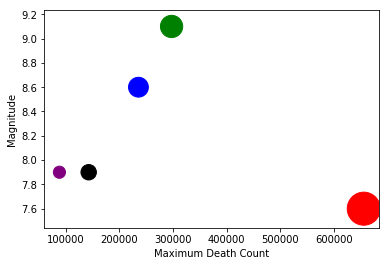

In [16]:
# Base size of dots based on frequency
np_death = np.array(Death_top5['Max_Deaths'])
np_death = np_death / 600

plt.scatter(Death_top5['Max_Deaths'], Death_top5['Mag_Value'], s=np_death, c=['red', 'green', 'blue', 'black', 'purple'], label='Country')

plt.xlabel('Maximum Death Count')
plt.ylabel('Magnitude')

plt.show()

In [17]:
Death_top5[['Country', 'Mag_Value', 'Mag_Units', 'Max_Deaths']]

,Country,Mag_Value,Mag_Units,Max_Deaths
583,China,7.6,Mw,655237.0
1238,Indonesia,9.1,Mw,297200.0
102,China,8.6,Ms,235502.0
116,Japan,7.9,Muk,142807.0
1308,China,7.9,Mw,88287.0


<a id='tangshan-earthquake'></a>

## 1976 Tangshan Earthquake
There is an obvious outlier in this data. China is really skewing our dataset. 

On further investigation, we saw that in 1976, this Tangshan Earthquake death count was overly reported at approximately *655,000 deaths*, but this number has since been stated to be around *240,000 to 255,000*. 
You can check out the link to this data [here](https://en.wikipedia.org/wiki/1976_Tangshan_earthquake).

With this being noted, we are changing the values to the more accurate values.

In [18]:
earthquakes.loc[583, 'Max_Deaths'] = 255000.0

### With this being shown, I think we are able to determine that Magnitude has correlation with death count.

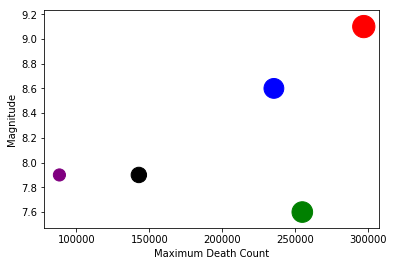

In [19]:
Death_top5 = earthquakes.sort_values('Max_Deaths',ascending=False).head(5)

np_death = np.array(Death_top5['Max_Deaths'])
np_death = np_death / 600

plt.scatter(Death_top5['Max_Deaths'], Death_top5['Mag_Value'], s=np_death, c=['red', 'green', 'blue', 'black', 'purple'], label='Country')

plt.xlabel('Maximum Death Count')
plt.ylabel('Magnitude')

plt.show()

<a id='top-fives'></a>

In [20]:
"""Here we pull out the top 5 values for Magnitude, Deaths, and Depth to do some further analyses.
    We categorize them based on the variables, create a new df, and place a label in the cat column for plotting"""
earthquakes_Mag_top5 = earthquakes.sort_values('Mag_Value',ascending=False).head(5)
earthquakes_Death_top5 = earthquakes.sort_values('Max_Deaths',ascending=False).head(5)
earthquakes_Depth_km_top5 = earthquakes.sort_values('Depth_km',ascending=False).head(5)

earthquakes_Mag_top5_sum = earthquakes_Mag_top5['Mag_Value'].sum()
earthquakes_Death_top5_sum = earthquakes_Death_top5['Max_Deaths'].sum()
earthquakes_Depth_km_top5_sum = earthquakes_Depth_km_top5['Depth_km'].sum()

earthquakes_Mag_top5['norm'] = earthquakes_Mag_top5['Mag_Value'] / earthquakes_Mag_top5_sum
earthquakes_Death_top5['norm'] = earthquakes_Death_top5['Max_Deaths'] / earthquakes_Death_top5_sum
earthquakes_Depth_km_top5['norm'] = earthquakes_Depth_km_top5['Depth_km'] / earthquakes_Depth_km_top5_sum

earthquakes_Mag_top5['cat'] = 'Mag'
earthquakes_Death_top5['cat'] = 'Death'
earthquakes_Depth_km_top5['cat'] = 'Depth'

In [21]:
earthquakes_Mag_top5

,UTC,Country,lat,lng,Depth_km,Mag,Secondary_Effects,PDE_Shaking_Deaths,PDE_Deaths,Utsu_Deaths,EM-DAT_Deaths,Other_Deaths,Mag_Value,Mag_Units,Year,Month,Day,Max_Deaths,norm,cat
396,1960-05-22 19:11:00,Chile,-38.235001,-73.046997,35.000000,9.5 Muk,T,NaN,NaN,5700.0,0.0,,9.5,Muk,1960,05,22,5700.0,0.207424,Mag
416,1964-03-28 03:36:00,United States,61.016998,-147.647995,6.600000,9.2 Muk,T,NaN,NaN,131.0,0.0,,9.2,Muk,1964,03,28,131.0,0.200873,Mag
1238,2004-12-26 00:58:00,Indonesia,3.287000,95.972000,30.000000,9.1 Mw,"T,L",NaN,297200.0,NaN,0.0,231000 283000 227898,9.1,Mw,2004,12,26,297200.0,0.198690,Mag
1335,2011-03-11 14:46:00,Japan,38.321999,142.369003,24.400000,9.0 Mw,T,NaN,NaN,NaN,0.0,15894,9.0,Mw,2011,03,11,0.0,0.196507,Mag
332,1952-11-04 16:58:00,Russian Federation,52.755001,160.057007,22.200001,9.0 Muk,T,NaN,NaN,NaN,0.0,,9.0,Muk,1952,11,04,0.0,0.196507,Mag


In [22]:
earthquakes_mag_death_depth = pd.concat([earthquakes_Mag_top5, earthquakes_Death_top5, earthquakes_Depth_km_top5], ignore_index=False)
earthquakes_mag_death_depth = earthquakes_mag_death_depth[['lng', 'lat', 'Country', 'Mag_Units', 'Mag_Value', 'Depth_km', 'Max_Deaths', 'norm', 'cat']].sort_index()

earthquakes_mag_death_depth_gdf = create_gdf(df=earthquakes_mag_death_depth)

<a id='top-five-map'></a>

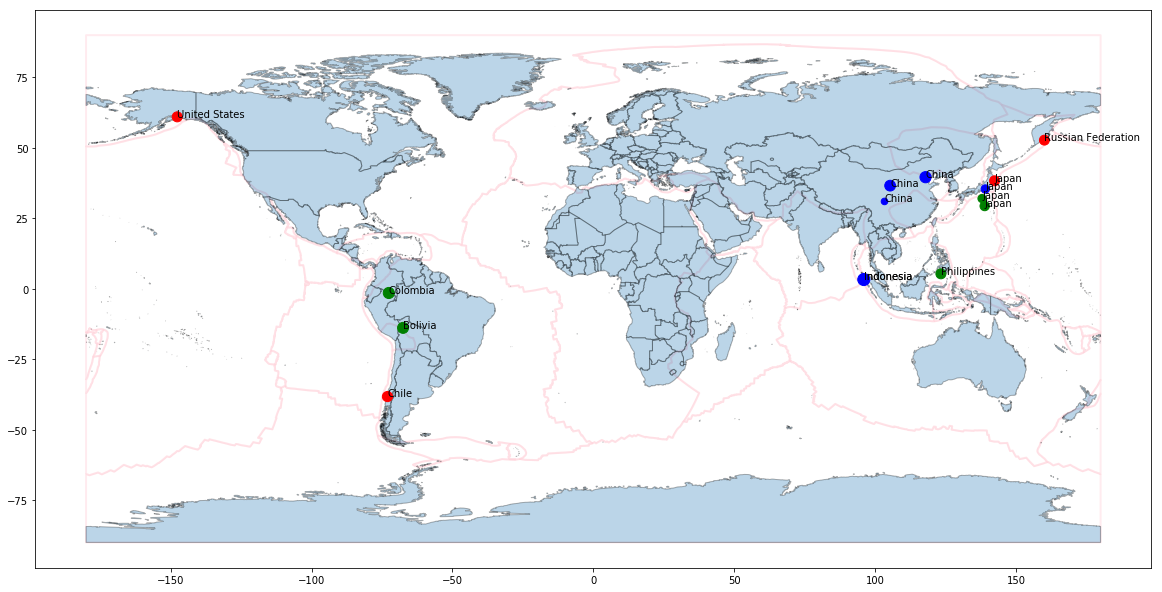

In [23]:
norm_size = np.array(earthquakes_mag_death_depth_gdf['norm'])
norm_size = norm_size * 500

fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
plates_gdf.plot(ax=ax, color='white', edgecolor='pink', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

colors = {'Mag':'red', 'Death':'blue', 'Depth':'green', 'G':'black'}
earthquakes_mag_death_depth_gdf.plot(
    ax=ax, 
    markersize=norm_size, 
    color=earthquakes_mag_death_depth_gdf['cat'].apply(lambda x: colors[x]),
    label=earthquakes_mag_death_depth_gdf['cat'].apply(lambda x: x)
)

for row in earthquakes_mag_death_depth_gdf.iterrows():
    plt.text(row[1].lng, row[1].lat, row[1].Country)

<a id='analysis-by-quantity-bar-graph'></a>

[Text(0,0,'China'),
 Text(0,0,'Indonesia'),
 Text(0,0,'Turkey'),
 Text(0,0,'Iran'),
 Text(0,0,'Japan'),
 Text(0,0,'Peru'),
 Text(0,0,'Taiwan'),
 Text(0,0,'Mexico'),
 Text(0,0,'Chile'),
 Text(0,0,'Greece'),
 Text(0,0,'Philippines'),
 Text(0,0,'Italy'),
 Text(0,0,'United States'),
 Text(0,0,'Afghanistan'),
 Text(0,0,'Pakistan'),
 Text(0,0,'India'),
 Text(0,0,'Colombia'),
 Text(0,0,'Algeria'),
 Text(0,0,'Ecuador'),
 Text(0,0,'Papua New Guinea'),
 Text(0,0,'Guatemala'),
 Text(0,0,'South Africa'),
 Text(0,0,'Russian Federation'),
 Text(0,0,'Argentina'),
 Text(0,0,'Burma')]

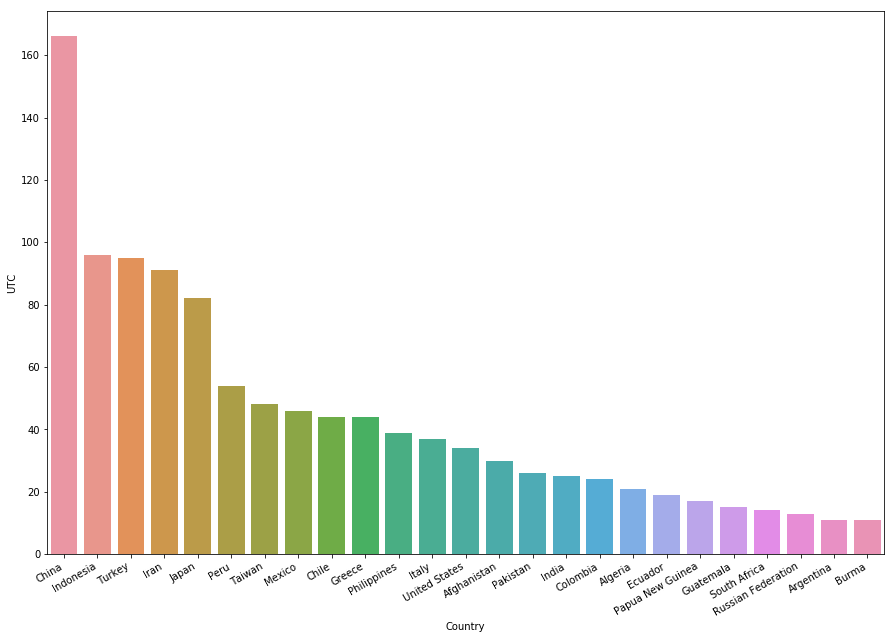

In [24]:
quakes_country_25 = earthquakes.groupby("Country").agg(len).reset_index().nlargest(25, columns="UTC")

f, ax = plt.subplots(figsize=(15, 10))

quake_count = sns.barplot(x='Country', y='UTC', data=quakes_country_25)
quake_count.set_xticklabels(quake_count.get_xticklabels(), rotation=30, ha="right")

<a id='pair-plot-corr'></a>

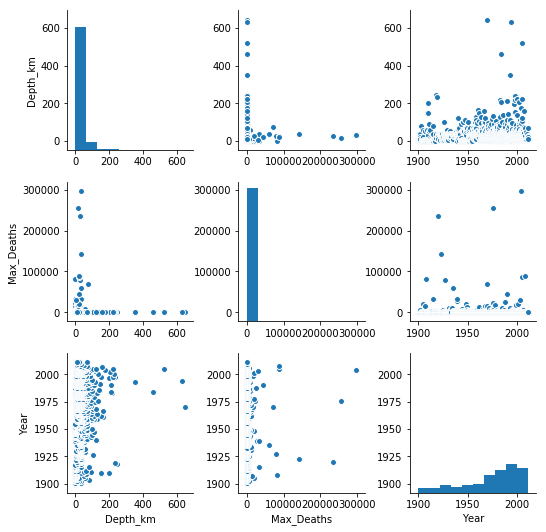

In [25]:
"""Trying to find any correlation between these columns. Most interesting find is between Depth and Mag"""
earthquakes_cont = earthquakes[["Depth_km", "Mag", "Max_Deaths", "Year"]]
earthquakes_cont = earthquakes_cont.replace("?", np.nan)
earthquakes_cont = earthquakes_cont.dropna()

sns.pairplot(earthquakes_cont, dropna=True)

<a id='death-count-frequency-corr'></a>

> We want to see how often earthquakes has happened  and the associated casualities. 
We have aggregated the `Total Deaths` and `Frequency of Earthquakes`. 
In the last 100 years, China has faced 166 earhquakes and more than a million casualities 
followed by Indonesia and Turkey

In [26]:
# Total deaths by country
occurrence_death = earthquakes[['Country', 'Max_Deaths']].groupby(['Country']).agg(['sum', 'count'])
occurrence_death.columns=['Total Deaths', 'Frequency of Earthquakes']

EQ_Casualities = occurrence_death.sort_values(['Frequency of Earthquakes'], ascending=False)
EQ_Casualities.head()

,Total Deaths,Frequency of Earthquakes
Country,,
China,738151.0,166
Indonesia,342112.0,96
Turkey,90836.0,95
Iran,152664.0,91
Japan,166997.0,82


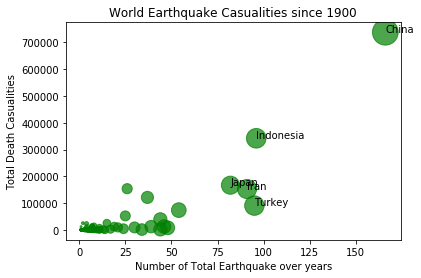

In [27]:
# Base size of dots based on frequency
np_death = np.array(EQ_Casualities['Frequency of Earthquakes'])
np_death = np_death*4

# Find correlation between Frequency and Total Deaths
plt.scatter(EQ_Casualities['Frequency of Earthquakes'], EQ_Casualities['Total Deaths'], s=np_death, color='green', alpha=0.7)

for row in EQ_Casualities.iterrows():
    if row[1]['Frequency of Earthquakes'] > 75:
        plt.text(row[1]['Frequency of Earthquakes'], row[1]['Total Deaths'], row[0])

plt.xlabel('Number of Total Earthquake over years')
plt.ylabel('Total Death Casualities')

plt.title('World Earthquake Casualities since 1900')

plt.show()

In [28]:
earthquakes.drop("UTC", inplace=True, axis=1)
earthquakes.to_json("JSONs_for_TP/earthquakes_original.json")

<a id='intro-to-new-data'></a>

## Developing a better understanding of the geologic setting where earthquakes occur.

Earthquakes are caused by geologic activity. Previously, predicting earthquakes has proven difficult because of the large variability in location, magnitude, and a host of other measured features. One aim of our group was to better understand the geologic setting where earthquakes occur by studying correlations between earthquakes and various geologic attributes and features. Below we outline the main areas of investigation.

The outer layer of the earth, called the crust, moves over the underlying layer, called the mantle, which contains liquid rock. The crust is composed of multiple pieces, called **tectonic plates**, that are constantly moving. When the plates contact and move by each other, the interaction can be felt as **earthquakes**. Additionally, other geologic features can be observed, including **volcanoes** and Hydrothermal **vents**. The **boundaries** between plates can be characterized in different ways and can cause different geologic features.

<a id='volcanoes-clean-data'></a>

## Cleaning the Volcano Data

In [29]:
class CleanVolcanoes(CleanData):
    def __init__(self, df):
        super(CleanVolcanoes, self).__init__(df)
        
    def replace_all_rows_by_regex(self, regex):
        self._df.replace(to_replace=regex, value="", regex=True, inplace=True)     

<a id='clean-volcanoes'></a>

In [30]:
volcanoes.columns = ["Name", "Country", "Type", "lat", "lng", "Elevation"]

In [31]:
clean_volcanos = CleanVolcanoes(volcanoes)

# Replacing new lines and spaces with empty strings
clean_volcanos.replace_all_rows_by_regex(regex="(\n|\n\s)")

# remove extra whitespace from these columns
clean_volcanos.strip_columns(columns=['lat', 'lng', 'Elevation'])

# Convert lat and lng vals to numeric
columns_to_convert = ['lat', 'lng', 'Elevation']
clean_volcanos.nan_to_float32(columns=columns_to_convert)


<a id='vents-clean-data'></a>

## Cleaning the Vents Data

In [32]:
class CleanVents(CleanData):
    def __init__(self, df):
        super(CleanVents, self).__init__(df)
        

<a id='clean-vents'></a>

In [33]:
# Renaming columns
vents.columns = ["Name", "Activity", "Tectonic Setting", "Region", "lat", "lng", "Depth", "Year&Discovered"]

In [34]:
# Some basic cleaning of the rows
vents = vents.replace(to_replace="(\n|\n\s)", value="", regex=True)

clean_vents = CleanVents(df=vents)

# Strip extra whitespace from these columns
clean_vents.strip_columns(columns=['lat', 'lng', 'Year&Discovered', 'Depth'])

# Turn appropriate columns to numeric
clean_vents.nan_to_float32(["lat", "lng", "Depth"])

## Create GeoPandas DFs to Graph Later On

In [35]:
earthquakes_gdf = create_gdf(df=earthquakes)
volcanoes_gdf = create_gdf(df=volcanoes)
vents_gdf = create_gdf(df=vents)

<a id='earthquakes-volcanoes-vents-map-1'></a>

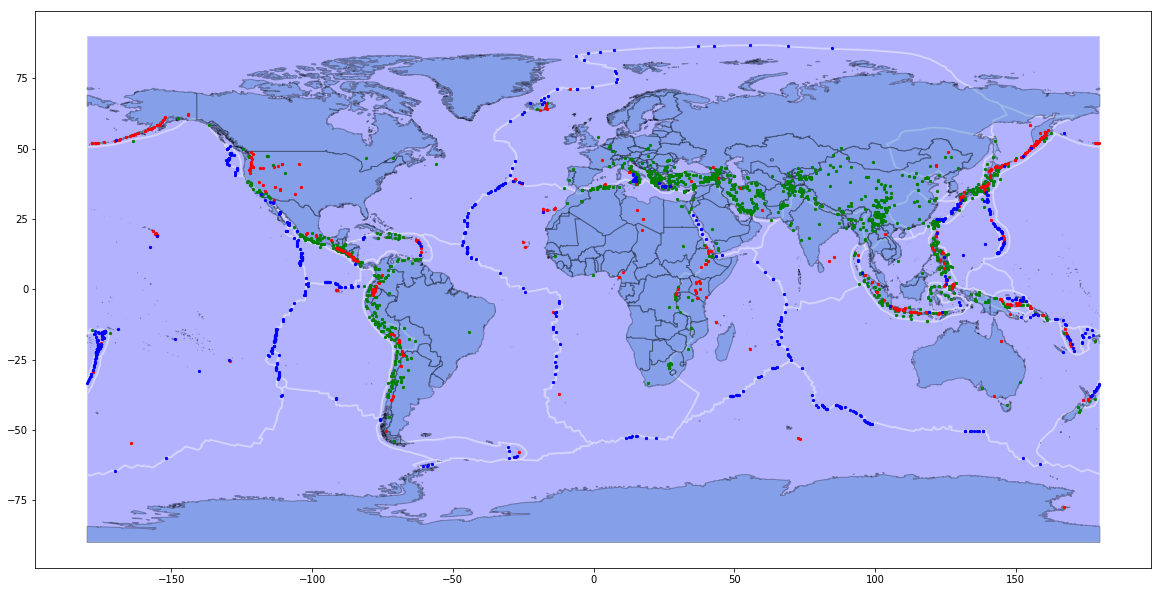

In [36]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
earthquakes_gdf.plot(ax=ax, markersize=5, color="green")
volcanoes_gdf.plot(ax=ax, markersize=5, color="red")
vents_gdf.plot(ax=ax, markersize=5, color="blue")

<a id='read-in-boundaries'></a>

In [37]:
"""Now that we have our data plotted out, we want to categorize the earthquakes based on location. 
    How close are they to the plates, and which plates are they closest to?"""
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

<a id='closest-point-logic-class'></a>

In [38]:
class ClosestPointLogic(object):
    """Logic class for calculating nearest distances between two GeoDataFrames"""
    def __init__(self, from_df, to_df, categories, extra_column_name):
        self._from_df = from_df
        self._to_df = to_df
        self._categories = categories
        self._extra_column_name = extra_column_name
    
    def get_geometries_from_gdf(self, column):
        """Grab the geometry columns within 'self._to' per category."""
        geometry_types = list()
        for df_type in self._categories:
            if df_type == 'None':
                df_type_geometry = self._to_df[self._to_df[column].str.contains("")].geometry
            else: 
                df_type_geometry = self._to_df[self._to_df[column].str.contains(df_type)].geometry

            geometry_types.append(df_type_geometry)
            
        # Add on the geometry from the overall df to compare against        
        geometry_types.extend([self._to_df.geometry]) 
        
        return geometry_types
    
    def calculate_nearest(self, to_column, dist_df):
        """Determine closest point based on category"""
        conditions = list()
        for col in self._categories:
            if not col == self._extra_column_name:
                # True or False. We want to know out of all the categories, this particular category 
                # is equal to the smallest distance. If it is, then this category is closest.
                dist_bool = (dist_df[self._extra_column_name] == dist_df[col])
                conditions.append(dist_bool)

        dist_df[to_column] = np.select(conditions, self._categories, default=np.nan)
        
        return dist_df
    
    def create_total_dist_df(self, series_geometry_list):
        total_dist_list = self._calculate_total_dist_list(series_geometry_list)
        
        dist_pd = pd.DataFrame(total_dist_list)
        dist_pd = dist_pd.transpose()

        dist_pd.columns = self._categories + [self._extra_column_name]

        return pd.concat([self._from_df, dist_pd], axis=1)
    
    def _calculate_total_dist_list(self, series_geometry_list):
        total_dist_list = []

        for geoseries in series_geometry_list:
            dist_list = self._quake_distance(geoseries)
            total_dist_list.append(dist_list)
            
        return total_dist_list
    
    def _quake_distance(self, geoseries):
        dist_list = []
        for quake in self._from_df.geometry:
            dist = np.min([quake.distance(series) for series in geoseries if series])
            dist_list.append(dist)

        return dist_list

<a id='volcano-prerequisites'></a>

### Volcanoes

**[Stratovolcanoes](https://en.wikipedia.org/wiki/Volcano#Stratovolcanoes_(composite_volcanoes)**
> Tall conical mountains composed of lava flows and other ejecta in alternate layers, the strata that gives rise to the name. Stratovolcanoes are also known as composite volcanoes because they are created from multiple structures during different kinds of eruptions. Strato/composite volcanoes are made of cinders, ash, and lava. Cinders and ash pile on top of each other, lava flows on top of the ash, where it cools and hardens, and then the process repeats. Classic examples include Mount Fuji in Japan, Mayon Volcano in the Philippines, and Mount Vesuvius and Stromboli in Italy.

**[Shield Volcanoes](https://en.wikipedia.org/wiki/Volcano#Shield_volcanoes)**
> Named for their broad, shield-like profiles, are formed by the eruption of low-viscosity lava that can flow a great distance from a vent. They generally do not explode catastrophically. Since low-viscosity magma is typically low in silica, shield volcanoes are more common in oceanic than continental settings. The Hawaiian volcanic chain is a series of shield cones, and they are common in Iceland, as well.

**[Cinder Cones](https://en.wikipedia.org/wiki/Volcano#Volcanic_cones_(cinder_cones))**
> Result from eruptions of mostly small pieces of scoria and pyroclastics (both resemble cinders, hence the name of this volcano type) that build up around the vent. These can be relatively short-lived eruptions that produce a cone-shaped hill perhaps 30 to 400 meters high. Most cinder cones erupt only once. Cinder cones may form as flank vents on larger volcanoes, or occur on their own. Parícutin in Mexico and Sunset Crater in Arizona are examples of cinder cones. In New Mexico, Caja del Rio is a volcanic field of over 60 cinder cones.

**[Submarine Volcanoes](https://en.wikipedia.org/wiki/Volcano#Underwater_volcanoes)**
> Common features of the ocean floor. In shallow water, active volcanoes disclose their presence by blasting steam and rocky debris high above the ocean's surface. In the ocean's deep, the tremendous weight of the water above prevents the explosive release of steam and gases; however, they can be detected by hydrophones and discoloration of water because of volcanic gases. Pillow lava is a common eruptive product of submarine volcanoes and is characterized by thick sequences of discontinuous pillow-shaped masses which form under water. Even large submarine eruptions may not disturb the ocean surface due to the rapid cooling effect and increased buoyancy of water (as compared to air) which often causes volcanic vents to form steep pillars on the ocean floor. Hydrothermal vents are common near these volcanoes, and some support peculiar ecosystems based on dissolved minerals. Over time, the formations created by submarine volcanoes may become so large that they break the ocean surface as new islands or floating pumice rafts.

**[Fissure Vents](https://en.wikipedia.org/wiki/Volcano#Fissure_vents)**
> Linear volcanic vent through which lava erupts, usually without any explosive activity. The vent is often a few meters wide and may be many kilometers long. Fissure vents can cause large flood basalts which run first in lava channels and later in lava tubes. After some time the eruption builds up spatter resp. ash cones and may concentrate on one or some of them. Small fissure vents may not be easily discernible from the air, but the crater rows (see Laki) or the canyons (see Eldgjá) built up by some of them are.

**[Caldera](https://en.wikipedia.org/wiki/Caldera)**
> large cauldron-like depression that forms following the evacuation of a magma chamber/reservoir. When large volumes of magma are erupted over a short time, structural support for the crust above the magma chamber is lost. The ground surface then collapses downward into the partially emptied magma chamber, leaving a massive depression at the surface (from one to dozens of kilometers in diameter). Although sometimes described as a crater, the feature is actually a type of sinkhole, as it is formed through subsidence and collapse rather than an explosion or impact. Only seven known caldera-forming collapses have occurred since the start of the 20th century, most recently at Bárðarbunga volcano in Iceland. 

**[Complex Volcano](https://en.wikipedia.org/wiki/Complex_volcano)**
> A complex volcano, also called a compound volcano, is mixed landform consisting of related volcanic centers and their associated lava flows and pyroclastic rock. They may form due to changes in eruptive habit or in the location of the principal vent area on a particular volcano. Stratovolcanoes can also form a large caldera that gets filled in by a lava dome, or else multiple small cinder cones, lava domes and craters may develop on the caldera's rim.

**[Volcanic Field](https://en.wikipedia.org/wiki/Volcanic_field)**
> Area of the Earth's crust that is prone to localized volcanic activity. They usually contain 10 to 100 volcanoes such as cinder cones and are usually in clusters. Lava flows may also occur. They may occur as a monogenetic volcanic field or a polygenetic volcanic field.

**[Lava Dome](https://en.wikipedia.org/wiki/Volcano#Lava_domes)**
> Built by slow eruptions of highly viscous lava. They are sometimes formed within the crater of a previous volcanic eruption, as in the case of Mount Saint Helens, but can also form independently, as in the case of Lassen Peak. Like stratovolcanoes, they can produce violent, explosive eruptions, but their lava generally does not flow far from the originating vent.

**[Somma Volcano](https://en.wikipedia.org/wiki/Somma_volcano)**
> Volcanic caldera that has been partially filled by a new central cone. The name comes from Mount Somma, a stratovolcano in southern Italy with a summit caldera in which the upper cone of Mount Vesuvius has grown.

**[Maar](https://en.wikipedia.org/wiki/Maar)**
> A broad, low-relief volcanic crater caused by a phreatomagmatic eruption (an explosion which occurs when groundwater comes into contact with hot lava or magma). A maar characteristically fills with water to form a relatively shallow crater lake which may also be called a maar. The name comes from a Moselle Franconian dialect word used for the circular lakes of the Daun area of Germany. Maars are shallow, flat-floored craters that scientists interpret as having formed above diatremes as a result of a violent expansion of magmatic gas or steam; deep erosion of a maar presumably would expose a diatreme. Maars range in size from 60 to 8,000 m (200 to 26,250 ft) across and from 10 to 200 m (33 to 656 ft) deep; most maars commonly fill with water to form natural lakes. Most maars have low rims composed of a mixture of loose fragments of volcanic rocks and rocks torn from the walls of the diatreme.

**[Pyroclastic cones](http://volcano.si.edu/learn_galleries.cfm?p=6)**
> The most abundant of volcanic structures. These small cones, named from a combination of the Greek words for fire (pyro) and broken (klastos), are built of fragmental material. They are found both as subsidiary features on larger stratovolcanoes and shield volcanoes or as independent volcanic structures. Pyroclastic cones typically range from a few tens of meters to a few hundred meters in height and are most often formed during single eruptions, when explosively ejected material accumulates around the vent. The slopes of pyroclastic cones consequently approach the angle of repose of its constituent materials. Pyroclastic cones, also known as cinder cones or scoria cones, can form rapidly, but remain active for long periods of time. Parícutin, the famous volcano born in Mexican cornfield in 1943, reached 80% of its 424 m height during its first year, but remained active for 9 years. Tuff cones are a variety of pyroclastic cone formed by more energetic explosions involving groundwater that extensively fragment ejecta, producing finer-grained ash deposits; they typically have steeper slopes and wider craters than cinder cones. 

**[Tuff Ring](https://en.wikipedia.org/wiki/Volcanic_cone)**
> A related type of small monogenetic volcano that is also produced by phreatic (hydrovolcanic) explosions directly associated with magma brought to the surface through a conduit from a deep-seated magma reservoir. . They are characterized by rims that have a low, broad topographic profiles and gentle topographic slopes that are 25 degrees or less. The maximum thickness of the pyroclastic debris comprising the rim of a typical tuff ring is generally thin, less than 50 meters (160 ft) to 100 meters (330 ft) thick. The pyroclastic materials that comprise their rim consist primarily of relatively fresh and unaltered, distinctly and thin-bedded volcanic surge and air fall deposits. Their rims also can contain variable amounts of local country rock (bedrock) blasted out of their crater. In contrast to tuff cones, the crater of a tuff ring generally has been excavated below the existing ground surface. As a result, water commonly fills a tuff ring’s crater to form a lake once eruptions cease. 

**[Volcanic Plug](https://en.wikipedia.org/wiki/Volcanic_plug)**
> Also called a volcanic neck or lava neck, is a volcanic object created when magma hardens within a vent on an active volcano. When present, a plug can cause an extreme build-up of pressure if rising volatile-charged magma is trapped beneath it, and this can sometimes lead to an explosive eruption. Glacial erosion can lead to exposure of the plug on one side, while a long slope of material remains on the opposite side. Such landforms are called crag and tail. If a plug is preserved, erosion may remove the surrounding rock while the erosion-resistant plug remains, producing a distinctive upstanding landform. 

<a id='volcanoes-closest-points'></a>

In [39]:
vol_types = ["Stratovolcano", "Caldera", "Shield", "Complex Volcano", "Submarine", "Volcanic Field", "Cinder Cone", "Dome",
        "Fissure vents", "Somma Volcano", "Maar", "Pyroclastic Cone", "Tuff Ring", "Plug", "None"]

volcanoes_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=volcanoes_gdf,
    categories=vol_types,
    extra_column_name='vol'
)

In [40]:
vol_series_geometry_list = volcanoes_to_earthquake_logic.get_geometries_from_gdf(column='Type')

quake_vol_dist = volcanoes_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=vol_series_geometry_list
)

quake_vol_dist = volcanoes_to_earthquake_logic.calculate_nearest(
    to_column='closest_vol',
    dist_df=quake_vol_dist
)

vol_distances_gdf = create_gdf(df=quake_vol_dist)

<a id='volcanoes-closest-point-map-1'></a>

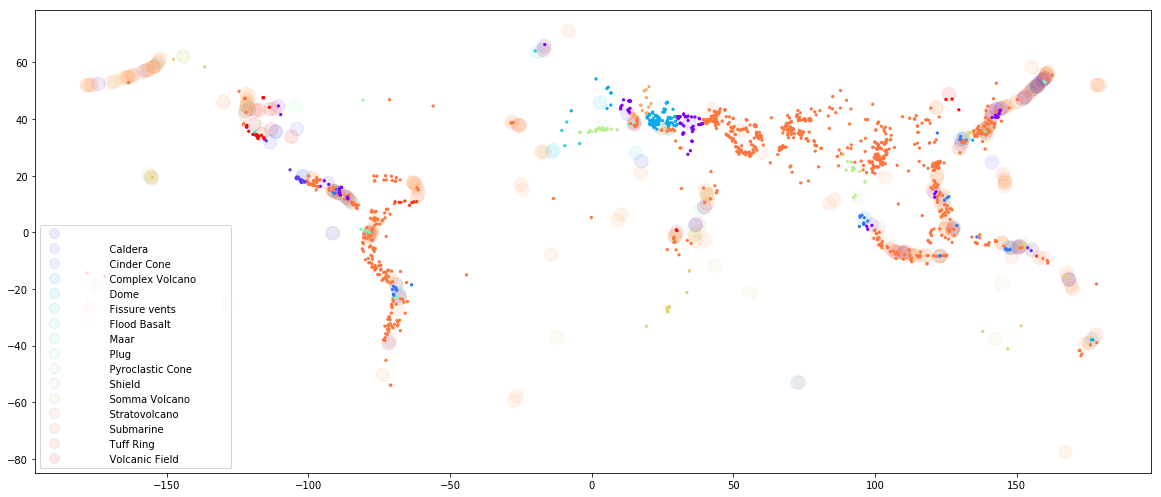

In [41]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# all points (earthquakes, volcanoes, and vents)
volcanoes_gdf.plot(ax=ax, column='Type', cmap='rainbow', markersize=180, alpha=0.1, legend=True)
vol_distances_gdf.plot(ax=ax, column='closest_vol', cmap='rainbow', markersize=5)

In [42]:
volcanoes_gdf.head()

,Name,Country,Type,lat,lng,Elevation,geometry
0,Abu,Japan,Shield,34.500000,131.600006,641.0,POINT (131.6000061035156 34.5)
1,Acamarachi,Chile,Stratovolcano,-23.299999,-67.620003,6046.0,POINT (-67.62000274658203 -23.29999923706055)
2,Acatenango,Guatemala,Stratovolcano,14.500000,-90.879997,3976.0,POINT (-90.87999725341797 14.5)
3,Acigöl-Nevsehir,Turkey,Caldera,38.570000,34.520000,1689.0,POINT (34.52000045776367 38.56999969482422)
4,Adams,USA,Stratovolcano,46.209999,-121.489998,3742.0,POINT (-121.4899978637695 46.20999908447266)


<a id='volcanoes-closest-point-bar-plot-1'></a>

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Maar'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Tuff Ring'),
 Text(0,0,'Plug')]

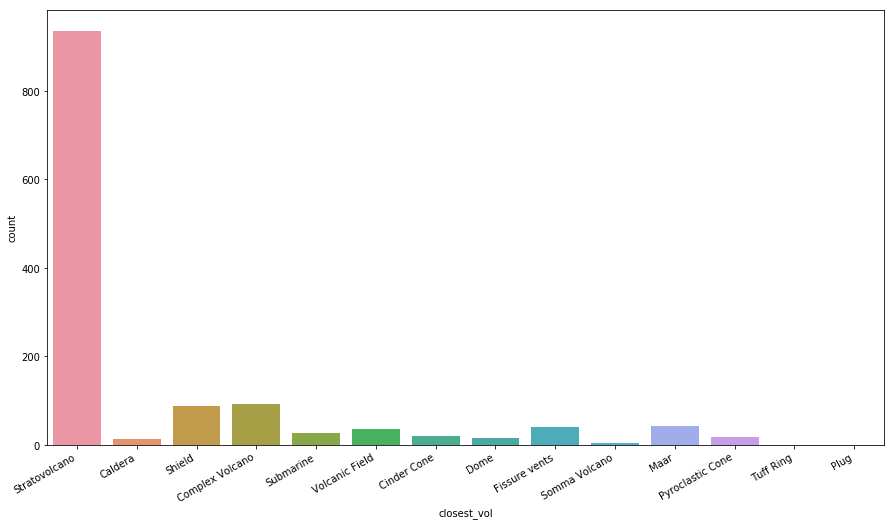

In [43]:
# At this point, we are wanting to visualize the distances between volcanoes and earthquakes. Notice here 
# how strato is way higher than the rest. This, we found, is a normalization issue. 
plt.subplots(figsize=(15, 8))
closest_vol_plot = sns.countplot(quake_vol_dist["closest_vol"])
closest_vol_plot.set_xticklabels(labels=vol_types, rotation=30, ha='right')

<a id='normalize-volcano-closest-points'></a>

In [44]:
# The count between the volcano types and the dist df do not always match up. So, you need a way to make up for 
# the missing data.
quakes_closest = dict(quake_vol_dist["closest_vol"].value_counts())
volcanoe_types = dict(volcanoes_gdf['Type'].value_counts())

type_counts = list()
for key, value in volcanoe_types.items():
    key = key.strip()
    compare = {'type': key, 'volcanoes': value, 'earthquakes': quakes_closest.get(key, 0)}
    
    type_counts.append(compare)

type_counts

[{'earthquakes': 936, 'type': 'Stratovolcano', 'volcanoes': 275},
 {'earthquakes': 92, 'type': 'Caldera', 'volcanoes': 40},
 {'earthquakes': 36, 'type': 'Shield', 'volcanoes': 34},
 {'earthquakes': 41, 'type': 'Complex Volcano', 'volcanoes': 16},
 {'earthquakes': 13, 'type': 'Submarine', 'volcanoes': 11},
 {'earthquakes': 27, 'type': 'Volcanic Field', 'volcanoes': 11},
 {'earthquakes': 0, 'type': '', 'volcanoes': 10},
 {'earthquakes': 19, 'type': 'Cinder Cone', 'volcanoes': 9},
 {'earthquakes': 89, 'type': 'Dome', 'volcanoes': 8},
 {'earthquakes': 5, 'type': 'Fissure vents', 'volcanoes': 4},
 {'earthquakes': 1, 'type': 'Maar', 'volcanoes': 3},
 {'earthquakes': 21, 'type': 'Somma Volcano', 'volcanoes': 3},
 {'earthquakes': 44, 'type': 'Pyroclastic Cone', 'volcanoes': 3},
 {'earthquakes': 0, 'type': 'Flood Basalt', 'volcanoes': 2},
 {'earthquakes': 1, 'type': 'Plug', 'volcanoes': 1},
 {'earthquakes': 0, 'type': 'Tuff Ring', 'volcanoes': 1}]

In [45]:
"""CORRECTING FOR DIFFERENCES IN NUM OF VOLCANOES"""
# distance count as shown above
type_list = [vol_type['type'] for vol_type in type_counts]

dist_count = np.array([vol_type['earthquakes'] for vol_type in type_counts])
vol_count = np.array([vol_type['volcanoes'] for vol_type in type_counts])

normalized_dist = np.divide(dist_count, vol_count)

<a id='plot-normalized-nearest-volcano'></a>

Text(0,0.5,'normalized distance')

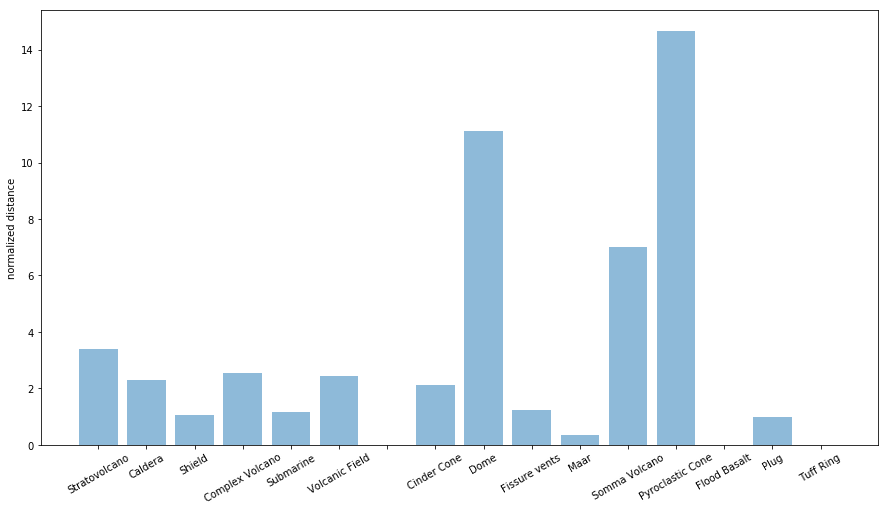

In [46]:
# Plotting out the normalized distances
# Notice the difference in the graph. Pyroclastic very obviously stands out
y_pos = np.arange(len(normalized_dist))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos, normalized_dist, alpha=0.5)
plt.xticks(y_pos, type_list, rotation=30)
plt.ylabel('normalized distance')

<a id='closest-vol-mag-pair-plot'></a>

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,''),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Maar'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Flood Basalt')]

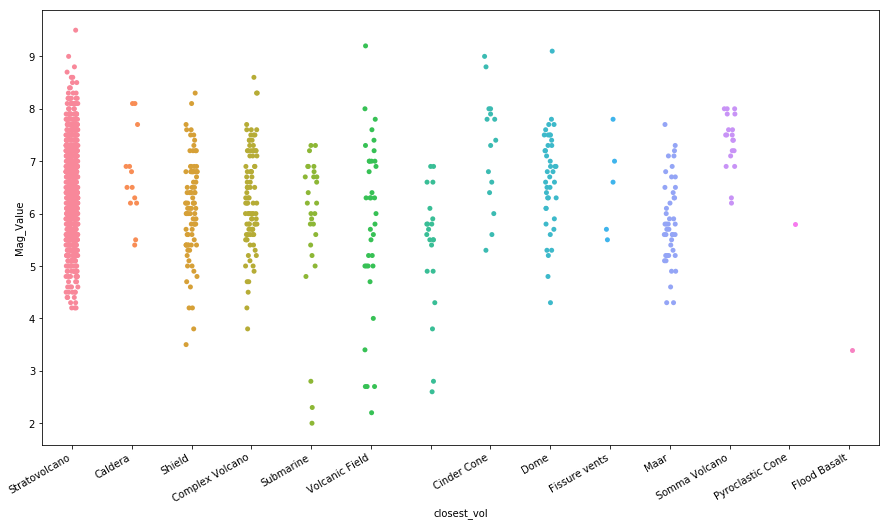

In [47]:
"""Strip plot showing correlations between Magnitude and the Closest Volcano"""
plt.figure(figsize=(15,8))

sp = sns.stripplot(x="closest_vol", y="Mag_Value", data=quake_vol_dist, jitter=True)
sp.set_xticklabels(labels=type_list, rotation=30, ha="right")

<a id='boundaries-prerequisites'></a>

### Boundary Types

*Boundary type names are given with their abbreviation used in visualizations and analyses in parentheses*

To a large extent earthquakes occur close to tectonic plate boundaries. Considering there are different types of plate boundaries, we hypothesize that earthquakes may occur more frequently close to particular plate boundary types.

**[Subduction Zone (SUB)](https://en.wikipedia.org/wiki/Subduction)**
> Regions where two plates move towards each other and one slides below the other into the mantle. Subduction zones are a specific type of convergent boundary (covered later). The lower plate sinks into the mantle, rather than remaining below the upper plate and affecting its features. Along most plate boundaries the amount of subduction is 2-8 cm per year.

**[Divergent Boundaries (OSR(oceanic)/CRB(continental))](http://geology.com/nsta/divergent-plate-boundaries.shtml)**
> Locations where plates are moving away from one another. This occurs above rising convection currents from the liquid mantle. The rising current pushes up on the bottom of the crust, lifting it and flowing laterally beneath it. This lateral flow causes the plate material above to be dragged along in the direction of flow. At the crest of the uplift, the overlying plate is stretched thin, breaks and pulls apart.

**[Transform Boundaries (OTF(oceanic)/CTF(continental))](http://geology.com/nsta/transform-plate-boundaries.shtml)**
> Locations where two plates slide along side one another. These are typically adjacent to divergent boundaries. Most transform faults are found in the ocean basin and connect offsets in the mid-ocean ridges. A smaller number connect mid-ocean ridges and subduction zones.

**[Convergent Boundary (OCB(oceanic)/CCB(continental))](https://en.wikipedia.org/wiki/Convergent_boundary and http://geology.com/nsta/convergent-plate-boundaries.shtml)**
> Where two or more tectonic plates move towards each other. As a result of pressure, friction, and plate material melting in the mantle, earthquakes and volcanoes are common near convergent boundaries. The when the plates come into contact with one another, one plate can be subducted (see subduction zone). The overlying plate can be fractured or compressed, causing deformations that can be ovserved as mountain ranges. Additionally the subducted plate can heat and cause volcanoes near the boundary.

<a id='plates-closest-points'></a>

In [48]:
"""Get geometry column as series per type of plate"""
plate_types = ["SUB", "CCB", "CRB", "CTF", "OCB", "OSR", "OTF"]

plates_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=boundaries_gdf,
    categories=plate_types,
    extra_column_name='plates'
)

In [49]:
plates_series_geometry_list = plates_to_earthquake_logic.get_geometries_from_gdf(column='STEPCLASS')

quake_plate_dist = plates_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=plates_series_geometry_list
)

quake_plate_dist = plates_to_earthquake_logic.calculate_nearest(
    to_column='closest_plate',
    dist_df=quake_plate_dist
)

boundary_distances_gdf = create_gdf(df=quake_plate_dist)

<a id='plates-closest-point-map-1'></a>

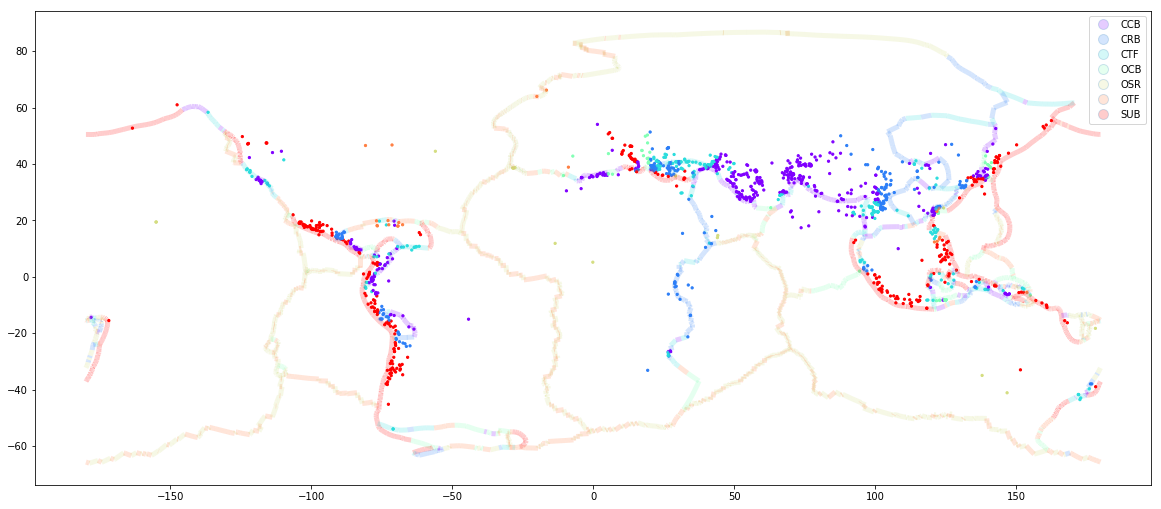

In [50]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
boundaries_gdf.plot(ax=ax, column='STEPCLASS', cmap='rainbow', lw=5.0, alpha=0.2, legend=True)

# all points (earthquakes, volcanoes, and vents)
boundary_distances_gdf.plot(ax=ax, column='closest_plate', cmap='rainbow', markersize=5)

<a id='plates-closest-point-bar-plot-1'></a>

[Text(0,0,'OCB'),
 Text(0,0,'CCB'),
 Text(0,0,'CTF'),
 Text(0,0,'SUB'),
 Text(0,0,'CRB'),
 Text(0,0,'OSR'),
 Text(0,0,'OTF')]

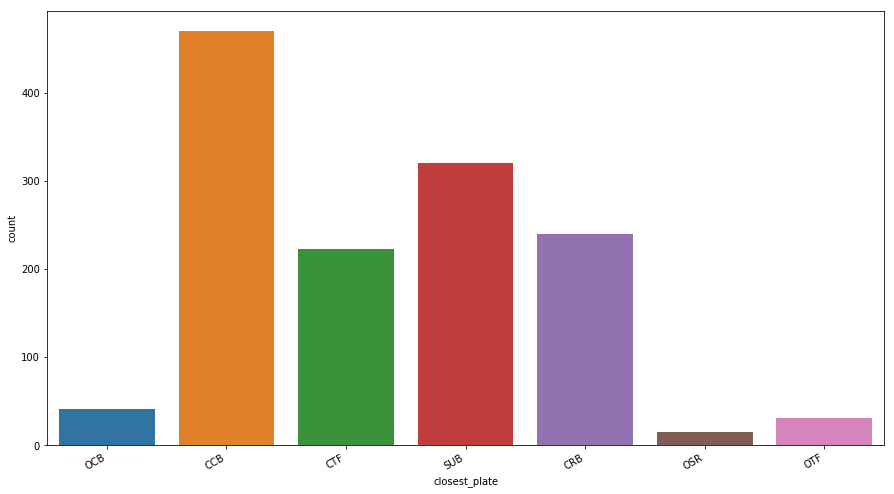

In [51]:
plt.subplots(figsize=(15, 8))
closest_plate_plot = sns.countplot(quake_plate_dist["closest_plate"])
closest_plate_plot.set_xticklabels(labels=quake_plate_dist["closest_plate"].unique(), rotation=30, ha='right')

<a id='normalize-plates-closest-points'></a>

In [52]:
"""The count between the plate types and the dist df do not always match up. So, you need a way to make up for 
    the missing data."""
quakes_closest = dict(quake_plate_dist["closest_plate"].value_counts())
plate_types = dict(boundaries_gdf['STEPCLASS'].value_counts())

type_counts = list()
for key, value in plate_types.items():
    key = key.strip()
    compare = {'type': key, 'plate': value, 'earthquakes': quakes_closest.get(key, 0)}
    
    type_counts.append(compare)

type_counts

[{'earthquakes': 15, 'plate': 1875, 'type': 'OSR'},
 {'earthquakes': 31, 'plate': 1147, 'type': 'OTF'},
 {'earthquakes': 320, 'plate': 1129, 'type': 'SUB'},
 {'earthquakes': 240, 'plate': 474, 'type': 'CRB'},
 {'earthquakes': 223, 'plate': 457, 'type': 'CTF'},
 {'earthquakes': 470, 'plate': 401, 'type': 'CCB'},
 {'earthquakes': 41, 'plate': 341, 'type': 'OCB'}]

In [53]:
"""CORRECTING FOR DIFFERENCES IN NUM OF PLATES"""
# distance count as shown above
type_list = [plate_type['type'] for plate_type in type_counts]

dist_count = np.array([plate_type['earthquakes'] for plate_type in type_counts])
plate_count = np.array([plate_type['plate'] for plate_type in type_counts])

normalized_dist = np.divide(dist_count, plate_count)

<a id='plot-normalized-nearest-plates'></a>

Text(0,0.5,'normalized distance')

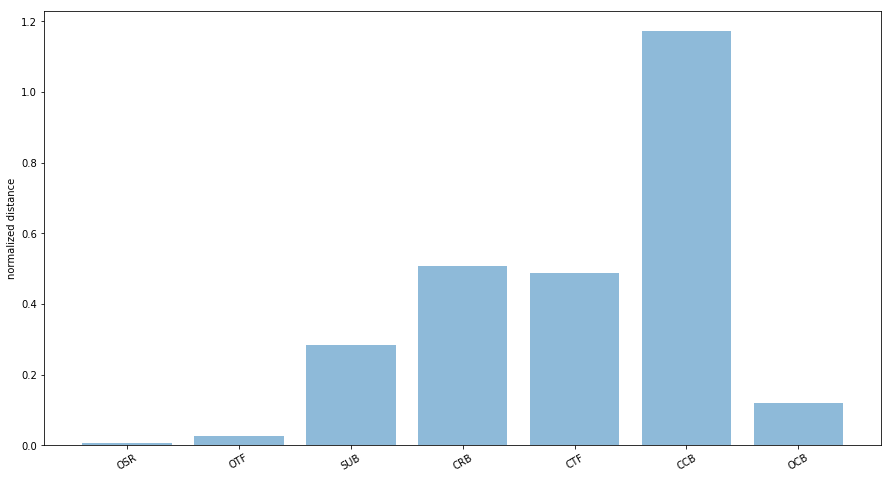

In [54]:
y_pos = np.arange(len(normalized_dist))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos, normalized_dist, alpha=0.5)
plt.xticks(y_pos, type_list, rotation=30)
plt.ylabel('normalized distance')